Python version used: **3.9.13**

Imports:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import csv
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import Word2Vec
from gensim import utils

Check that CUDA is available (when using my own system):

In [3]:
torch.cuda.is_available()

True

# Q1:

(a)

In [21]:
with open("PADL-Q1.csv") as q1_file:
  q1_data = []
  q1_dataset = csv.reader(q1_file, delimiter=',')
  for row in q1_dataset:
    if row[0] != 'x1':
      q1_data.append(row)

In [22]:
pca = PCA(n_components=5)
pca.fit(q1_data)
newData = pca.fit_transform(q1_data)
pca_var_percentage = pca.explained_variance_ratio_
print(pca_var_percentage)

[0.53846279 0.30067823 0.1026325  0.04605826 0.01216823]


In [23]:
three_dims = pca_var_percentage[0]+pca_var_percentage[1]+pca_var_percentage[2]
print("Information retained with 3 variables = %f%%\n"%(three_dims*100.0))
print("Information retained with 4 variables = %f%%"%((three_dims + pca_var_percentage[3])*100.0))

Information retained with 3 variables = 94.177351%

Information retained with 4 variables = 98.783177%


Reducing the dimensionality of the dataset by 1 dimension causes information loss of 1.22%. Reducing it by 2 dimensions (down to 3) causes information loss of 5.82% however it is now possible to plot the dataset on a 3D axis, whereas this is not possible with 4 dimensions. Therefore, D_min = 3.





(b)

In [24]:
pca2 = PCA(n_components=3)
pca2.fit(q1_data)
newData2 = pca2.fit_transform(q1_data)
pca2_components = pca2.components_

In [25]:
i = 1
for line in pca2_components:
    print("PC%i: %f*x1 + %f*x2 + %f*x3 + %f*x4 + %f*x5\n"%(i,line[0],line[1],line[2],line[3],line[4]))
    i+=1

PC1: -0.092819*x1 + 0.025272*x2 + -0.348770*x3 + 0.145083*x4 + -0.920900*x5

PC2: 0.005624*x1 + -0.298705*x2 + -0.114221*x3 + -0.940623*x4 + -0.113695*x5

PC3: 0.112668*x1 + -0.133156*x2 + 0.914203*x3 + -0.023934*x4 + -0.365014*x5



# Q2:

Read data into a Pandas Dataframe:

In [26]:
q2_data = pd.read_csv("PADL-Q2-train.csv")
q2_data

,x,y,z,w,out
0,66.4774,1.6495,0.7613,0.1,-0.0209
1,15.1422,2.2292,0.0050,0.1,0.1281
2,87.9859,2.1449,0.2217,0.1,0.1289
3,79.4979,2.0901,0.0396,0.1,0.1442
4,36.5181,2.0992,0.2040,0.0,-0.0131
...,...,...,...,...,...
75,7.5622,2.2608,0.0785,0.1,0.3158
76,10.7811,2.0351,0.6939,0.1,0.0325
77,57.3595,2.2470,0.3667,0.0,0.0675
78,4.4803,1.6897,0.0544,0.1,0.3627


Split into train and test data:

In [27]:
X = q2_data.drop('out', axis=1)
y = q2_data['out']
# Split 70:10 train:test
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.125)

Fit a LR model, compare predicted vs actual values, calculate R2 score:

In [28]:
regr = LinearRegression()
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)

r2 = r2_score(y_test,y_pred)

for y1,y2 in zip(y_test,y_pred):
    print(f'Predicted vs actual: {y2:.4f} vs {y1}')

print(f'\nR2 score: {r2:.6f}')

Predicted vs actual: -0.0084 vs 0.0025
Predicted vs actual: 0.0067 vs 0.0087
Predicted vs actual: 0.0969 vs 0.0593
Predicted vs actual: -0.0972 vs -0.1166
Predicted vs actual: 0.0827 vs 0.1615
Predicted vs actual: 0.0310 vs -0.0876
Predicted vs actual: -0.0619 vs 0.0174
Predicted vs actual: -0.1107 vs -0.0074
Predicted vs actual: -0.1375 vs -0.2512
Predicted vs actual: 0.1607 vs 0.3158

R2 score: 0.642794


# Q3:

(a)

In [3]:
with open("PADL-Q3.txt",'r') as q3_file:
    words = []
    raw_data = q3_file
    for line in q3_file:
        for word in line.split():
            words.append(word)

The following tile removes punctuation from the text then selects all triplets where the middle word is "and". It then selects the before and after words and adds them as a 3-tuple into a list.

In [4]:
punctuation = """!'()*+,— -./:;<=>?@[\]^_`{|"}~#$%&"""
words_no_punc = [''.join(char for char in word if char not in punctuation) for word in words]
triplets = []
for i in range(1,len(words)-1):
    if words_no_punc[i] == "and":
        triplets.append((words_no_punc[i-1],words_no_punc[i],words_no_punc[i+1]))
triplets

[('States', 'and', 'most'),
 ('cost', 'and', 'with'),
 ('eclipses', 'and', 'predominates'),
 ('emotions', 'and', 'that'),
 ('reasoning', 'and', 'observing'),
 ('gibe', 'and', 'a'),
 ('motives', 'and', 'actions'),
 ('delicate', 'and', 'finely'),
 ('him', 'and', 'that'),
 ('dubious', 'and', 'questionable'),
 ('happiness', 'and', 'the'),
 ('books', 'and', 'alternating'),
 ('cocaine', 'and', 'ambition'),
 ('drug', 'and', 'the'),
 ('crime', 'and', 'occupied'),
 ('faculties', 'and', 'extraordinary'),
 ('clues', 'and', 'clearing'),
 ('Trincomalee', 'and', 'finally'),
 ('delicately', 'and', 'successfully'),
 ('friend', 'and', 'companion'),
 ('wooing', 'and', 'with'),
 ('again', 'and', 'to'),
 ('lit', 'and', 'even'),
 ('chest', 'and', 'his'),
 ('mood', 'and', 'habit'),
 ('attitude', 'and', 'manner'),
 ('dreams', 'and', 'was'),
 ('bell', 'and', 'was'),
 ('cigars', 'and', 'indicated'),
 ('case', 'and', 'a'),
 ('fire', 'and', 'looked'),
 ('seven', 'and', 'a'),
 ('lately', 'and', 'that'),
 ('clumsy

(b)

This procedure iterates over all words in L and finds any triplet where the last 3 letters of the final word of the triplet are the same 3 letters as the last 3 letters of word W chosen from L.

In [5]:
L = ['gold','diamond','robbery','bank','police']
matches = []
for W in L:
    for t in triplets:
        if t[2][-3:] == W[-3:]:
            matches.append((' '.join(t),W))

matches

[('away and told', 'gold'),
 ('rapidly and told', 'gold'),
 ('Silk and Gold', 'gold'),
 ('indemnify and hold', 'gold'),
 ('delicacy and every', 'robbery'),
 ('pay and very', 'robbery'),
 ('ten and every', 'robbery'),
 ('Abbots and Archery', 'robbery'),
 ('police and every', 'robbery'),
 ('Air and scenery', 'robbery'),
 ('long and very', 'robbery'),
 ('armchair and cheery', 'robbery'),
 ('police and very', 'robbery'),
 ('do and Frank', 'bank'),
 ('mercifully and thank', 'bank'),
 ('help and advice', 'police')]

(c)

In [6]:
class Q3Data(object):
    def __init__(self,dir):
        self.dir = dir
    def __iter__(self):
        with open("PADL-Q3.txt") as q3_dataset:
            dataset = []
            for line in q3_dataset:
                dataset.append(utils.simple_preprocess(line))
        for i in range(len(dataset)-1):
            if dataset[i] == []:
                dataset[i] = dataset[i-1] + dataset[i+1]
            yield dataset[i]

In [7]:
sentences = Q3Data("PADL-Q3.txt")
model = Word2Vec(min_count=4)
model.build_vocab(sentences)
model.train(sentences,total_examples=12753,epochs=25)

(2485505, 3708075)

In [8]:
similarities = []
for match in matches:
    triplet = match[0].split()
    try:
        sim = model.wv.similarity(triplet[0].lower(),triplet[2].lower())
        print(triplet[0],sim,triplet[2])
        similarities.append((sim,triplet[0],triplet[2]))
    except KeyError:
        print("\nThe word '"+triplet[0]+"' or the word '"+triplet[2]+"' is not in the text above min_count times, therefore the similarity cannot be computed\n")

away 0.18918677 told
rapidly 0.052297138 told
Silk 0.5863457 Gold

The word 'indemnify' or the word 'hold' is not in the text above min_count times, therefore the similarity cannot be computed

delicacy 0.20294267 every
pay 0.2717545 very
ten 0.1477366 every

The word 'Abbots' or the word 'Archery' is not in the text above min_count times, therefore the similarity cannot be computed

police -0.0027108828 every

The word 'Air' or the word 'scenery' is not in the text above min_count times, therefore the similarity cannot be computed

long 0.0041154977 very

The word 'armchair' or the word 'cheery' is not in the text above min_count times, therefore the similarity cannot be computed

police -0.001833939 very
do 0.15193689 Frank

The word 'mercifully' or the word 'thank' is not in the text above min_count times, therefore the similarity cannot be computed

help 0.46436232 advice


In [9]:
sorted(similarities,reverse=True)[:5]

[(0.5863457, 'Silk', 'Gold'),
 (0.46436232, 'help', 'advice'),
 (0.2717545, 'pay', 'very'),
 (0.20294267, 'delicacy', 'every'),
 (0.18918677, 'away', 'told')]

# Q4:

Define MLP using Fully Connected and ReLU layers only:

In [ ]:
class MultiplyMLP(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(MultiplyMLP, self).__init__()
        self.linear1 = nn.Linear(inputSize,hiddenSize)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hiddenSize,1)
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

Function to generate random training data in the range [-100,100):

In [ ]:
def generate_data(low,high,num_samples):
    x1 = np.random.uniform(low,high, num_samples)
    x2 = np.random.uniform(low,high, num_samples)
    y_true = x1 * x2
    data = torch.tensor(np.column_stack((x1, x2))).to(torch.float32)
    labels = torch.tensor(y_true).reshape(-1, 1)
    return data, labels

Run training loop to train on random data:

In [ ]:
# Define hyperparameters
input_size = 2
hidden_size = 64
learning_rate = 0.01
num_epochs = 1000
batch_size = 32
num_samples = 3000
# Use L1Loss for absolute error
criterion = nn.L1Loss()

q4_model = MultiplyMLP(input_size,hidden_size)
optimiser = optim.Adam(q4_model.parameters(), lr=learning_rate)

# Create list to store loss values in for plotting
losses = []

for epoch in range(num_epochs):
    for i in range(0,num_samples,batch_size):
        data,labels = generate_data(-100,100,batch_size)

        output = q4_model(data)
        loss = criterion(output, labels)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    if (epoch+1) % 250 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if (epoch+1) % 10 == 0:
        losses.append(loss.item())



Epoch [250/1000], Loss: 627.1599
Epoch [500/1000], Loss: 58.6277
Epoch [750/1000], Loss: 26.6937
Epoch [1000/1000], Loss: 24.4932


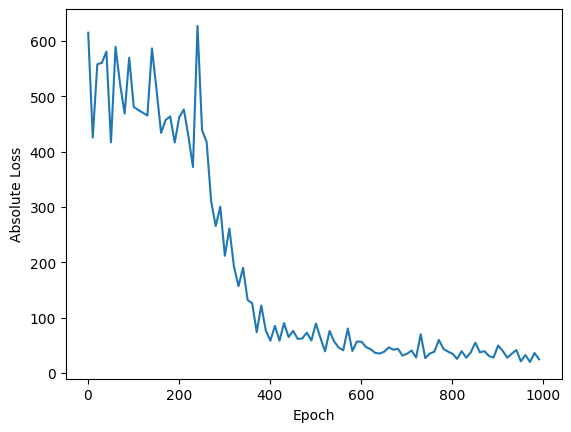

In [ ]:
epochs = np.arange(1,1001,10)
plt.xlabel("Epoch")
plt.ylabel("Absolute Loss")
plt.plot(epochs,losses)

Evaluate and compare random example's predicted value vs real value:

In [ ]:
x,y = generate_data(-100,100,1)

with torch.no_grad():
    q4_model.eval()
    y_pred = q4_model(x)
l1 = criterion(y_pred,y).item()

print(f'x1, x2 = {x[0][0]:.7f}, {x[0][1]:.7f}')
print(f'Predicted vs Actual value: {y_pred[0][0]} vs {y[0][0]}')
print(f'Test L1 Loss: {l1:.7f}')

x1, x2 = -97.3343201, 84.2313766
Predicted vs Actual value: -8170.90576171875 vs -8198.603655411494
Test L1 Loss: 27.6978937


Generate 100 random samples to test and evaluate average loss within range of training data:

In [ ]:
x_val,y_val = generate_data(-100,100,100)
q4_model.eval()

total_loss = 0
for i in range(100):
    with torch.no_grad():
        y_pred = q4_model(x_val[i])
        l1 = criterion(y_pred,y_val[i])
    total_loss+=l1

print(f'Average loss within range of training data = {total_loss/100:.7f}')

Average loss within range of training data = 22.3594613


Generate 100 random samples outside range of training data and calculate average loss:

In [ ]:
x_test_neg,y_test_neg = generate_data(-500,-100,50)
x_test_pos,y_test_pos = generate_data(100.01,500,50)

total_loss = 0
for i in range(50):
    with torch.no_grad():
        y_pred = q4_model(x_test_neg[i])
        l1 = criterion(y_pred,y_test_neg[i])
    total_loss+=l1

for i in range(50):
    with torch.no_grad():
        y_pred = q4_model(x_test_pos[i])
        l1 = criterion(y_pred,y_test_pos[i])
    total_loss+=l1

print(f'Average loss outside range of training data = {total_loss/100:.7f}')

Average loss outside range of training data = 56874.2062989


# Q5:

(a)

In [4]:
class ClocksDataset(Dataset):
    """Custom Clocks Dataset"""

    def __init__(self,img_dir):

        self.img_dir = img_dir
        images = []
        labels = []

        for i in range(10000):
            images.append(f"{i:04d}.png")
            labels.append(f"{i:04d}.txt")
        
        self.images = sorted(images)
        self.labels = sorted(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        img_path = self.images[idx]
        label_path = self.labels[idx]

        image = (read_image(self.img_dir + img_path)).to(torch.float32)/255.0
        label = self.read_label(self.img_dir + label_path)

        return image,label
    
    def read_label(self,label_path):
        with open(label_path) as label_file:
            raw_label = label_file.read()
        label_vals = raw_label.split(':')
        label_vals = [float(val) for val in label_vals]
        hours = label_vals[0]
        mins = label_vals[1]
        return torch.tensor((hours,mins), dtype=torch.float32)

In [5]:
batch_size = 32
dataset = ClocksDataset("clocks_dataset/train/")
dataloader = DataLoader(dataset, batch_size=batch_size)
train_data,validation_data = torch.utils.data.random_split(dataset,[9600,400])

In [6]:
dataset[0][0].shape

torch.Size([3, 448, 448])

Label value: tensor(5.) , tensor(49.)
Human readable: 5:49


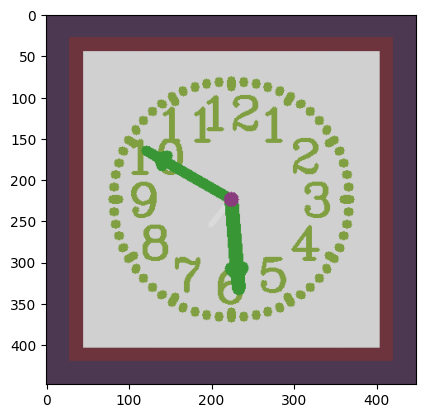

In [7]:
random_img = np.random.randint(0,8999)
print("Label value:",train_data[random_img][1][0],',',train_data[random_img][1][1])
print("Human readable:",str(int(train_data[random_img][1][0].item()))+':'+str(int(train_data[random_img][1][1].item())))
plt.imshow(train_data[random_img][0].permute(1,2,0))

In [8]:
train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(validation_data,batch_size=batch_size,shuffle=True)

images,labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 448, 448])
torch.Size([32, 2])


(b)

In [16]:
class ClocksCNN(nn.Module):
    def __init__(self):
        super(ClocksCNN,self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 8 x 224 x 224
            nn.Conv2d(in_channels=8,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 32 x 112 x 112
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=4), # 64 x 28 x 28
            nn.Flatten())
        
        self.MLPhours = nn.Sequential(
            nn.Linear(in_features=64*28*28,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=12)
        )

        self.MLPmins = nn.Sequential(
            nn.Linear(in_features=64*28*28,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=1),
            nn.Sigmoid()
        )

        self.MLP = nn.Sequential(
            nn.Linear(in_features=64*28*28,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=144)
        )

    def forward(self,x):
        x = self.layers(x)
        x = self.MLP(x)
        return x

q5_model = ClocksCNN()

In [17]:
total_params = sum(p.numel() for p in q5_model.parameters() if p.requires_grad)
print(total_params)

25750573


(c)

In [18]:
# TODO: Justify the chosen loss function(s)
criterion_q5_h = nn.L1Loss()
criterion_q5_m = nn.L1Loss()

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q5_model = q5_model.to(device)
q5_model.train()

num_epochs = 3
optim = torch.optim.Adam(q5_model.parameters(), lr=0.01)
iterations_per_epoch = len(train_loader)

losses_q5 = []

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images,labels = images.to(device), labels.to(device)
        pred = q5_model(images)
        pred_to_val = []
        for p in pred:
            pred_to_val.append((divmod((p.argmax()*5).item(),60)))
        pred_to_val = torch.tensor(pred_to_val,dtype = torch.float32,requires_grad=True).cuda()
        loss = criterion_q5_h(pred_to_val,labels)
        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i+1)%10 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, iterations_per_epoch, loss.item()))
        if (i+1) % 10 == 0:
            losses_q5.append(loss.item())


Epoch [1/3], Iteration [10/300], Loss: 12.1250
Epoch [1/3], Iteration [20/300], Loss: 13.0469
Epoch [1/3], Iteration [30/300], Loss: 14.4844
Epoch [1/3], Iteration [40/300], Loss: 13.2500
Epoch [1/3], Iteration [50/300], Loss: 13.2969
Epoch [1/3], Iteration [60/300], Loss: 11.2656
Epoch [1/3], Iteration [70/300], Loss: 13.4844
Epoch [1/3], Iteration [80/300], Loss: 13.1875
Epoch [1/3], Iteration [90/300], Loss: 13.1406
Epoch [1/3], Iteration [100/300], Loss: 12.7344
Epoch [1/3], Iteration [110/300], Loss: 13.3125
Epoch [1/3], Iteration [120/300], Loss: 11.6875
Epoch [1/3], Iteration [130/300], Loss: 11.7500
Epoch [1/3], Iteration [140/300], Loss: 12.0156
Epoch [1/3], Iteration [150/300], Loss: 14.0000
Epoch [1/3], Iteration [160/300], Loss: 14.9844
Epoch [1/3], Iteration [170/300], Loss: 14.8594
Epoch [1/3], Iteration [180/300], Loss: 10.6562
Epoch [1/3], Iteration [190/300], Loss: 10.7500
Epoch [1/3], Iteration [200/300], Loss: 11.2812
Epoch [1/3], Iteration [210/300], Loss: 10.7500
E

KeyboardInterrupt: 

In [ ]:
device = torch.device("cpu")

q5_model = q5_model.to(device)
q5_model.eval()
images, labels = next(iter(train_loader))
pred_test = q5_model(images)
print(pred_test.shape)
print(labels.shape)

torch.Size([32, 144])
torch.Size([32, 2])


In [ ]:
for val in pred_test:
    print(torch.tensor(divmod((val.argmax()*5).item(),60),dtype=torch.float32))

tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([10., 35.])
tensor([10., 35.])
tensor([10., 35.])
tensor([ 6., 40.])
tensor([10., 35.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([10.,  0.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([7., 0.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([ 6., 40.])
tensor([10., 55.])
tensor([ 1., 45.])
tensor([10.,  0.])
tensor([10., 55.])
tensor([ 6., 40.])
tensor([ 6., 40.])


In [ ]:
loss_hours = criterion_q5_h(pred_h_test[:,0],labels[:,0])
loss_mins = criterion_q5_m(pred_m_test[:,0],labels[:,1])
loss = loss_hours + loss_mins
print(loss_hours,loss_mins)
print("Loss =", loss)

tensor(2.7472, grad_fn=<MeanBackward0>) tensor(18.5698, grad_fn=<MeanBackward0>)
Loss = tensor(21.3170, grad_fn=<AddBackward0>)


In [ ]:
def time_diff(pred_h,pred_m,label):
    output = 0
    for i in range(batch_size):

        mins1 = pred_h[i].item() + pred_m[i].item()
        mins2 = label[i][0].item()*60 + label[i][1].item()
        diff = np.abs(mins1-mins2)

        output += np.min([diff,720-diff])
    return torch.tensor(output,dtype=torch.float32,requires_grad=True)

In [ ]:
time_diff(pred_h_test[:,0],pred_m_test[:,0],labels)

tensor(6153.8418, requires_grad=True)

Training loop:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q5_model = q5_model.to(device)
q5_model.train()

num_epochs = 3
optim = torch.optim.Adam(q5_model.parameters(), lr=0.01)
iterations_per_epoch = len(train_loader)

losses_q5 = []

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        images,labels = images.to(device), labels.to(device)
        pred_h,pred_m = q5_model(images)
        loss_h = criterion_q5_h(pred_h[:,0],labels[:,0])
        loss_m = criterion_q5_m(pred_m[:,0],labels[:,1])
        loss = loss_h*60 + loss_m
        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i+1)%10 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss (hours): {:.4f}, Loss (mins): {:.4f}'.format(epoch+1, num_epochs, i+1, iterations_per_epoch, loss_h.item(), loss_m.item()))
        if (i+1) % 10 == 0:
            losses_q5.append((loss_h.item(),loss_m.item()))
    


Epoch [1/3], Iteration [10/300], Loss (hours): 6.2812, Loss (mins): 28.2500
Epoch [1/3], Iteration [20/300], Loss (hours): 7.5000, Loss (mins): 28.1875
Epoch [1/3], Iteration [30/300], Loss (hours): 7.0312, Loss (mins): 28.4062
Epoch [1/3], Iteration [40/300], Loss (hours): 6.9062, Loss (mins): 25.7188
Epoch [1/3], Iteration [50/300], Loss (hours): 6.4062, Loss (mins): 27.2188
Epoch [1/3], Iteration [60/300], Loss (hours): 6.5000, Loss (mins): 27.5625
Epoch [1/3], Iteration [70/300], Loss (hours): 7.4688, Loss (mins): 33.0312
Epoch [1/3], Iteration [80/300], Loss (hours): 6.4688, Loss (mins): 27.2500
Epoch [1/3], Iteration [90/300], Loss (hours): 6.5312, Loss (mins): 33.9062
Epoch [1/3], Iteration [100/300], Loss (hours): 6.6875, Loss (mins): 35.8125
Epoch [1/3], Iteration [110/300], Loss (hours): 6.1562, Loss (mins): 26.6875
Epoch [1/3], Iteration [120/300], Loss (hours): 7.2812, Loss (mins): 31.4062
Epoch [1/3], Iteration [130/300], Loss (hours): 6.5625, Loss (mins): 29.0000
Epoch [1

KeyboardInterrupt: 

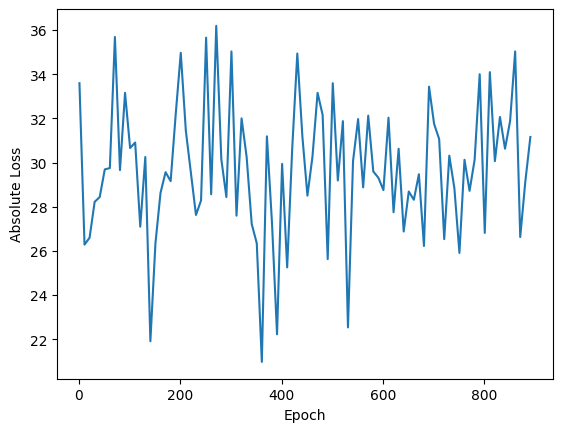

In [ ]:
epochs = np.arange(1,901,10)
losses_h_q5, losses_m_q5 = [],[]
for (loss_h,loss_m) in losses_q5:
    losses_h_q5.append(loss_h)
    losses_m_q5.append(loss_m)
plt.xlabel("Epoch")
plt.ylabel("Absolute Loss")
plt.plot(epochs,losses_m_q5)

Test on a random image from validation set:

In [ ]:
device = torch.device("cpu")
q5_model = q5_model.to(device)
q5_model.eval()
images_v, labels_v = next(iter(valid_loader))

pred_h_valid,pred_m_valid = q5_model(images_v)

loss_hours_v = criterion_q5_h(pred_h_valid[0].argmax(),labels_v[:,0][0])
loss_mins_v = criterion_q5_m(pred_m_valid[:,0][0],labels_v[:,1][0])
loss_v = loss_hours_v + loss_mins_v
print("Prediction:",pred_h_valid[0].argmax(),pred_m_valid[0])
print("Actual:",labels_v[:,0][0],labels_v[:,1][0])
print(loss_hours_v,loss_mins_v)
print("Loss =", loss_v)

Prediction: tensor(0) tensor([60.], grad_fn=<SelectBackward0>)
Actual: tensor(4.) tensor(44.)
tensor(4.) tensor(16., grad_fn=<MeanBackward0>)
Loss = tensor(20., grad_fn=<AddBackward0>)


In [11]:
class ClocksCNN(nn.Module):
    def __init__(self):
        super(ClocksCNN,self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 16 x 224 x 224
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 32 x 112 x 112
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # 64 x 56 x 56
            nn.Flatten(),
            nn.Dropout(0.5)
        )

        self.MLPhours = nn.Sequential(
            nn.Linear(in_features=64*56*56,out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256,out_features=12)
        )

        self.MLPmins = nn.Sequential(
            nn.Linear(in_features=64*56*56,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=1)
        )


    def forward(self,x):
        x = self.layers(x)
        x = x.view(x.size(0),-1)
        hours = self.MLPhours(x)
        mins = self.MLPmins(x)
        return hours,mins.view(-1)

q5_model = ClocksCNN()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q5_model = q5_model.to(device)
q5_model.train()

num_epochs = 10
optim = torch.optim.SGD(q5_model.parameters(),lr=0.001)
criterion_h = nn.CrossEntropyLoss()
criterion_m = nn.MSELoss()
iterations_per_epoch=300
for epoch in range(num_epochs):
    for i,(images,labels) in enumerate(train_loader):
        images,labels = images.to(device),labels.to(device)
        labels_h,labels_m = labels[:,0],labels[:,1]
        h,m = q5_model(images)
        loss1 = criterion_h(h,labels_h.long())
        loss2 = criterion_m(m,labels_m)
        loss = loss1/6 + loss2/60
        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i+1)%10 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss (hours): {:.4f}, Loss (mins): {:.4f}'.format(epoch+1, num_epochs, i+1, iterations_per_epoch, loss1.item(), loss2.item()))

Epoch [1/10], Iteration [10/300], Loss (hours): 2.5211, Loss (mins): 361.5641
Epoch [1/10], Iteration [20/300], Loss (hours): 2.4846, Loss (mins): 254.7366
Epoch [1/10], Iteration [30/300], Loss (hours): 2.4100, Loss (mins): 233.0524
Epoch [1/10], Iteration [40/300], Loss (hours): 2.4620, Loss (mins): 267.1330
Epoch [1/10], Iteration [50/300], Loss (hours): 2.4537, Loss (mins): 207.4722
Epoch [1/10], Iteration [60/300], Loss (hours): 2.4593, Loss (mins): 269.7238
Epoch [1/10], Iteration [70/300], Loss (hours): 2.4437, Loss (mins): 378.1772
Epoch [1/10], Iteration [80/300], Loss (hours): 2.4545, Loss (mins): 327.9628
Epoch [1/10], Iteration [90/300], Loss (hours): 2.4749, Loss (mins): 366.2007
Epoch [1/10], Iteration [100/300], Loss (hours): 2.4510, Loss (mins): 309.0334
Epoch [1/10], Iteration [110/300], Loss (hours): 2.4652, Loss (mins): 299.4860
Epoch [1/10], Iteration [120/300], Loss (hours): 2.4485, Loss (mins): 334.3381
Epoch [1/10], Iteration [130/300], Loss (hours): 2.4261, Loss

In [38]:
device = torch.device("cpu")
q5_model = q5_model.to(device)
q5_model.eval()
images_v, labels_v = next(iter(valid_loader))

pred_h_valid,pred_m_valid = q5_model(images_v)

# write code here to display prediction vs actual and difference between them

Actual time: 5.000000:52.000000
Predicted time: 5.000000:49.102375


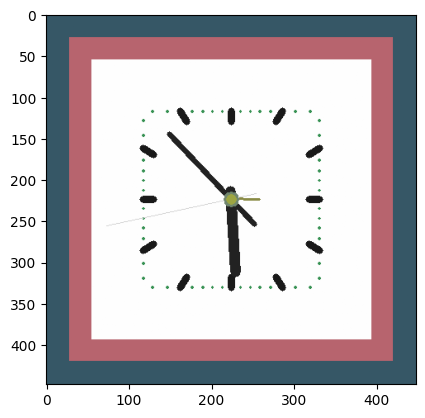

In [39]:
plt.imshow(images_v[0].permute(1,2,0))
print("Actual time: %f:%f"%(labels_v[0][0],labels_v[0][1]))
print("Predicted time: %f:%f"%(pred_h_valid[0].argmax().item(),pred_m_valid[0].item()))